In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mpld3
mpld3.enable_notebook()
from scipy.integrate import odeint
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

In [2]:
covid_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [3]:
covid_data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,850,856,868,872,876,880,898,916,933,946
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,752,754,755,755,758,760,761,761,761,761
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,43,43,45,45,45,45,48,48,48,48


In [10]:
covid_data.rename(columns={"Country/Region": "Location"}, inplace = True)

In [11]:
covid_data_india = covid_data.loc[covid_data['Location'] == 'India']
covid_data_india.head()

,Province/State,Location,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20
131,NaN,India,21.0,78.0,0,0,0,0,0,0,...,59695,62808,67161,70768,74292,78055,81997,85784,90648,95698


Text(0.5, 0, 'Date')

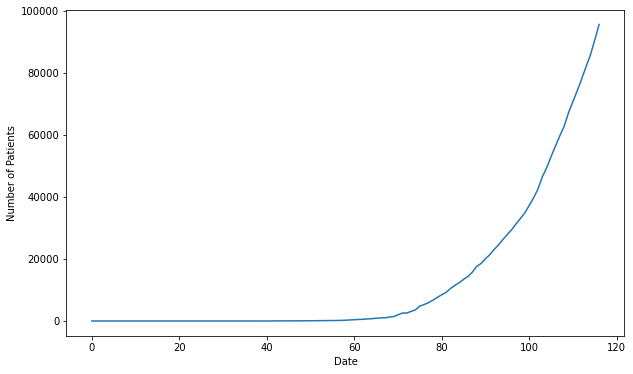

In [98]:
# covid_data_india.columns[4:].values

# covid_india.to_numpy()[0]

plt.figure(figsize=(10,6))
plt.plot(covid_india.to_numpy()[0])
plt.ylabel("Number of Patients")
plt.xlabel("Date")

In [5]:
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")

In [6]:
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

In [7]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [8]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

In [28]:
agegroups = agegroup_lookup["India"]
beds_per_100k = beds_lookup["India"]
outbreak_shift = 30
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [31]:
covid_india = covid_data[covid_data['Location'] == 'India']

In [32]:
covid_india.drop(['Province/State', 'Location' , 'Lat', 'Long'], axis=1, inplace = True)

In [78]:
data5 =covid_india.to_numpy()[0]

In [79]:
data5

array([    0,     0,     0,     0,     0,     0,     0,     0,     1,
           1,     1,     2,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     5,     5,    28,    30,    31,
          34,    39,    43,    56,    62,    73,    82,   102,   113,
         119,   142,   156,   194,   244,   330,   396,   499,   536,
         657,   727,   887,   987,  1024,  1251,  1397,  1998,  2543,
        2567,  3082,  3588,  4778,  5311,  5916,  6725,  7598,  8446,
        9205, 10453, 11487, 12322, 13430, 14352, 15722, 17615, 18539,
       20080, 21370, 23077, 24530, 26283, 27890, 29451, 31324, 33062,
       34863, 37257, 39699, 42505, 46437, 49400, 52987, 56351, 59695,
       62808, 67161, 70768, 74292, 78055, 81997, 85784, 90648, 95698],
      dtype=int64)

In [80]:
days = outbreak_shift + len(data5)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data5))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array




def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[3][x]

In [81]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

{'R_0_start': 2.2658939717552173,
 'k': 0.2001852867067365,
 'x0': 119.9999999999979,
 'R_0_end': 1.7536087738149875,
 'prob_I_to_C': 0.010000359926020283,
 'prob_C_to_D': 0.2251346814775854,
 's': 0.003}

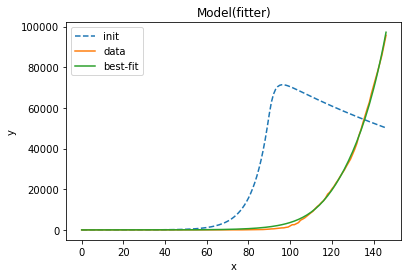

In [102]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)
result.plot_fit(datafmt="-", show_init=True);

result.best_values